In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/bank-churn/train.csv
/kaggle/input/bank-churn/test.csv


In [22]:
import warnings
import pandas as pd

warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('/kaggle/input/bank-churn/train.csv')

# Exploring data and gain insights

In [3]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df.shape

(165034, 14)

Посмотрим, какие значения и какие типы в каждой колонке

In [5]:
from tabulate import tabulate

def print_col_info(df):
    uniq_col_count = []
    for col in df:
        uniq_count = df[col].unique()
        types = set([type(x) for x in uniq_count])
        uniq_col_count.append([col, len(uniq_count), uniq_count[:10], types])

    uniq_col_count.sort(key=lambda x: x[1])

    print(tabulate(uniq_col_count, headers=['Col', 'Uniq_num', 'Values (top 10)', 'Types']))
    
print_col_info(df)

Col                Uniq_num  Values (top 10)                                                           Types
---------------  ----------  ------------------------------------------------------------------------  -------------------------
Gender                    2  ['Male' 'Female']                                                         {<class 'str'>}
HasCrCard                 2  [1. 0.]                                                                   {<class 'numpy.float64'>}
IsActiveMember            2  [0. 1.]                                                                   {<class 'numpy.float64'>}
Exited                    2  [0 1]                                                                     {<class 'numpy.int64'>}
Geography                 3  ['France' 'Spain' 'Germany']                                              {<class 'str'>}
NumOfProducts             4  [2 1 3 4]                                                                 {<class 'numpy.int64'>}
Tenure      

In [6]:
df.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# проверим на наличие дубликатов строк

df.duplicated().sum()

0

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


In [10]:
data = df[[
    'CreditScore',  # кредитный рейтинг. Мин 350, макс 850
    'Age',  # возраст. Мин 18, макс 82
    'Tenure',  # срок владения. Мин 0, макс 10
    'Balance',  # баланс на счете. Мин 0, макс 250к
    'NumOfProducts',  # кол-во продуктов банка. Мин 1, макс 4
    'HasCrCard',  # есть ердика или нет
    'IsActiveMember',  # активный клиент или нет
    'EstimatedSalary'  # зарплата клиента. Мин 11, макс 200к
]]

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [31]:
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Функция для вычисления величины D
def calculate_D(data, labels, centers):
    overall_center = data.mean(axis=0)
    overall_distances = np.linalg.norm(data - overall_center, axis=1)
    cluster_distances = np.linalg.norm(data - centers[labels], axis=1)
    D = (np.mean(overall_distances)**2 - np.mean(cluster_distances)**2) / np.mean(overall_distances)**2
    return D

Величина D показывает, какая доля R^2 объясняется разбросом кластерных центров вокруг общего центра. (R^2 - средний квадрат расстояния от наблюдения до центра всей совокупности).

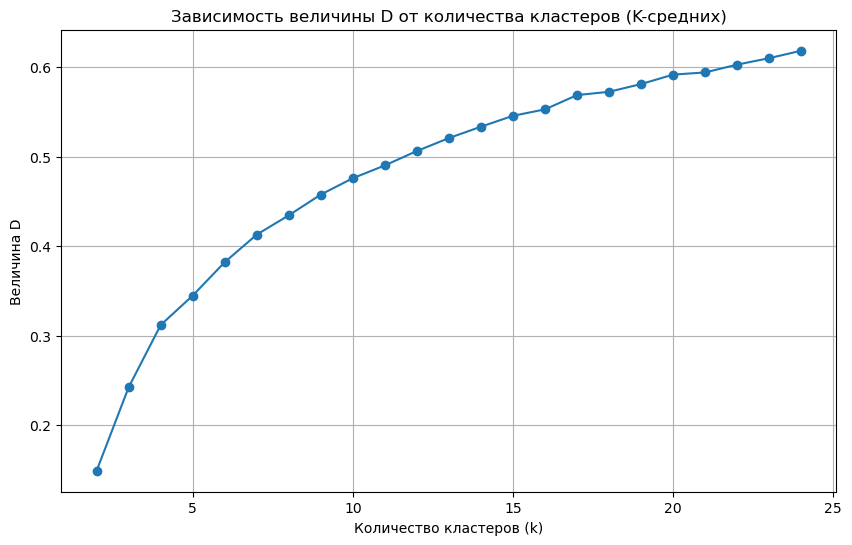

In [13]:
import matplotlib.pyplot as plt

# Функция для вычисления величины D для различных значений k
def calculate_D_for_kmeans(data, k_range):
    D_values = []
    for k in k_range:
        dbscan = DBSCAN(min_samples=k, random_state=42)
        dbscan.fit(data)
        labels = dbscan.labels_
        centers = dbscan.cluster_centers_
        D = calculate_D(data, labels, centers)
        D_values.append(D)
    return D_values

# Диапазон значений k
k_range = range(2, 25)
D_values_kmeans = calculate_D_for_kmeans(data_scaled, k_range)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(k_range, D_values_kmeans, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Величина D')
plt.title('Зависимость величины D от количества кластеров (K-средних)')
plt.grid(True)
plt.show()


In [15]:
# Кластеризация с помощью K-средних
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(data_scaled)
labels_kmeans = kmeans.labels_
centers_kmeans = kmeans.cluster_centers_

# Вычисление величины D
D_kmeans = calculate_D(data_scaled, labels_kmeans, centers_kmeans)
print(f"Величина D для K-средних при K = 5: {D_kmeans}")

Величина D для K-средних при K = 5: 0.4760442115058771


In [24]:
# Принадлежность объектов к кластерам
data['Cluster_KMeans'] = labels_kmeans
display(data.head())

# Координаты центров кластеров в исходных и стандартизованных значениях
centers_kmeans_original = scaler.inverse_transform(centers_kmeans)
print("Центры кластеров в исходных значениях:\n")
display(
    pd.DataFrame(centers_kmeans_original, columns=data.columns[:-1])
)
print("\nЦентры кластеров в стандартизованных значениях:\n")
display(
    pd.DataFrame(centers_kmeans, columns=data.columns[:-1])
)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Cluster_KMeans
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,6
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,3
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,6


Центры кластеров в исходных значениях:



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,658.963107,35.987303,5.006516,125067.909416,1.226055,1.000000e+00,1.000000e+00,115403.137422
1,656.190641,36.461014,2.598785,14657.592480,1.795448,1.000000e+00,1.482148e-14,107571.351664
2,656.391715,37.139475,5.011676,22397.170026,1.802863,1.698641e-14,3.652634e-14,112234.006312
3,653.824166,36.445577,7.529048,13833.165003,1.790771,1.000000e+00,1.504352e-14,117723.754620
4,653.017999,59.125069,4.819734,56167.272319,1.375115,8.551781e-01,6.993723e-01,109616.968274
5,657.950623,35.392074,5.050792,6535.966213,1.825685,1.000000e+00,1.000000e+00,151886.299978
6,656.608538,35.601338,5.049952,12196.165017,1.825550,1.000000e+00,9.959223e-01,62114.682981
7,657.879749,36.398440,5.042275,23225.673476,1.838239,2.209344e-14,1.000000e+00,112406.536901
8,656.130766,38.178345,5.048283,125161.697812,1.141505,1.000000e+00,-1.776357e-14,114551.901885
9,656.358311,38.381909,4.948707,123670.674318,1.046908,2.531308e-14,4.921201e-01,112707.299991



Центры кластеров в стандартизованных значениях:



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.031319,-0.241180,-0.004931,1.107810,-0.600199,0.571263,1.004470,0.056237
1,-0.003292,-0.187757,-0.862950,-0.649827,0.440450,0.571263,-0.995550,-0.099487
2,-0.000782,-0.111243,-0.003092,-0.526620,0.454001,-1.750507,-0.995550,-0.006777
3,-0.032835,-0.189498,0.893999,-0.662951,0.431901,0.571263,-0.995550,0.102379
4,-0.042899,2.368192,-0.071493,0.010971,-0.327770,0.235020,0.403208,-0.058813
5,0.018679,-0.308307,0.010847,-0.779116,0.495711,0.571263,1.004470,0.781654
6,0.001925,-0.284707,0.010548,-0.689011,0.495464,0.571263,0.996314,-1.003329
7,0.017794,-0.194814,0.007812,-0.513431,0.518655,-1.750507,1.004470,-0.003346
8,-0.004040,0.005916,0.009953,1.109303,-0.754727,0.571263,-0.995550,0.039311
9,-0.001199,0.028873,-0.025532,1.085567,-0.927618,-1.750507,-0.011300,0.002634


In [29]:
def target_in_cluster(data, labels, label_key):
    target = df['Exited']
    for label in list(set(labels)):
        target_in_cluster = target[data[label_key] == label]
        print(f'Cluster {label}: Target {sum(target_in_cluster)/len(target_in_cluster)}')

In [30]:
target_in_cluster(data, labels_kmeans, 'Cluster_KMeans')

Cluster 0: Target 0.12744346492909162
Cluster 1: Target 0.2202739433992432
Cluster 2: Target 0.24824056301983366
Cluster 3: Target 0.2034548944337812
Cluster 4: Target 0.4669005631982273
Cluster 5: Target 0.07230492393260265
Cluster 6: Target 0.07142402849329009
Cluster 7: Target 0.10901307239507683
Cluster 8: Target 0.3590895082111566
Cluster 9: Target 0.3062741599762117


Выводы:

**Кластер 4 – самый проблемный**

Высокий риск оттока (Target ≈ 0.47) при среднем/выше среднего балансе и зарплате.

Как правило, это клиенты средней возрастной группы, часто с 1–2 продуктами и неоднозначной активностью; можно трактовать как «ценные, но неудовлетворённые» клиенты, у которых много денег в банке, но слабая лояльность.​

**Кластер 8 – богатые, но нестабильные**


Вторая по величине вероятность оттока (≈ 0.36), при этом обычно высокий баланс и хороший доход.​

Похоже на обеспеченных клиентов с нормальным кредитным скором и несколькими продуктами, которые активно пользуются услугами, но чувствительны к тарифам/сервису и легко уходят к конкурентам.​

**Кластеры 1, 2, 3, 9 – средний риск**

Риск оттока в диапазоне 0.20–0.31: это «серые зоны» — клиенты без ярко выраженной лояльности, у части которых уже заметна склонность к уходу.​

Как правило, это клиенты со средним возрастом, умеренным балансом и 1–2 продуктами; могут быть как активными, так и частично пассивными, и на них стоит направлять стандартные retention‑кампании.​

**Кластеры 0 и 3 – относительно лояльные масс‑клиенты**

Вероятность оттока около 0.13–0.20, что ниже общей по выборке; часто это клиенты с невысоким или средним балансом, нормальным кредитным скором и базовым набором продуктов (часто 1–2).​

Их можно трактовать как массовый стабильный сегмент: доход и баланс невысокие, но они, скорее всего, довольны базовыми услугами и не проявляют активного интереса к смене банка.​

**Кластеры 5, 6, 7 – наименее рискованные**

Очень низкий риск оттока (≈ 0.07–0.11); обычно это либо давние клиенты с большим стажем, либо наоборот относительно молодые, но очень активные и хорошо «зафиксированные» на продуктах банка.​

Часто имеют хороший кредитный скор, 1 продукт (классический счёт/карта), стабильные, но не обязательно высокие балансы; это ядро лояльной клиентской базы, к которому достаточно поддерживающих коммуникаций.​

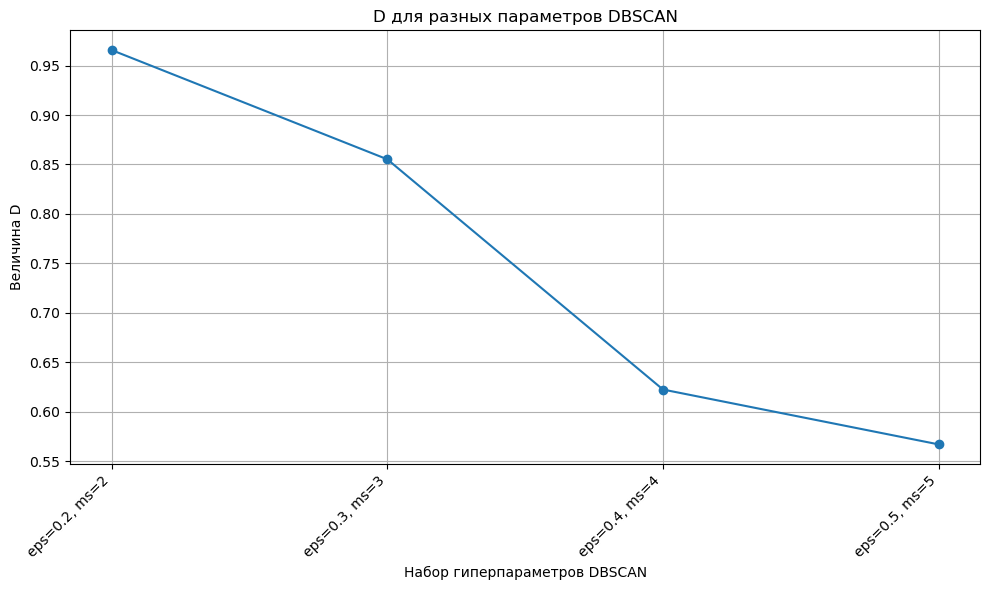

In [34]:
def calculate_D_for_dbscan(data, eps_list, min_samples_list):
    D_values = []

    for eps, min_samples in zip(eps_list, min_samples_list):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(data)

        # игнорируем шум (-1)
        mask = labels != -1
        labels_clean = labels[mask]
        data_clean = data[mask]

        if len(np.unique(labels_clean)) == 0:
            D_values.append(None)
            continue

        # считаем «центры» как среднее по точкам кластера
        centers = []
        for lab in np.unique(labels_clean):
            centers.append(data_clean[labels_clean == lab].mean(axis=0))
        centers = np.vstack(centers)

        D = calculate_D(data_clean, labels_clean, centers)
        D_values.append(D)

    return D_values

eps_list = [0.2, 0.3, 0.4, 0.5]
min_samples_list = range(2, 12)

D_values_dbscan = calculate_D_for_dbscan(data_scaled, eps_list, min_samples_list)

# Построение графика
param_labels = [f'eps={e}, ms={m}' for e, m in zip(eps_list, min_samples_list)]
x = range(len(param_labels))

plt.figure(figsize=(10, 6))
plt.plot(x, D_values_dbscan, marker='o')
plt.xticks(x, param_labels, rotation=45, ha='right')
plt.xlabel('Набор гиперпараметров DBSCAN')
plt.ylabel('Величина D')
plt.title('D для разных параметров DBSCAN')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
dbscan = DBSCAN(eps=0.2, min_samples=2)
dbscan.fit(data_scaled)

labels_dbscan = dbscan.labels_

# игнорируем шум (-1) при расчёте D
mask = labels_dbscan != -1
data_clean = data_scaled[mask]
labels_clean = labels_dbscan[mask]

unique_labels = np.unique(labels_clean)

# считаем центры как среднее по точкам кластера
centers_dbscan = np.vstack([
    data_clean[labels_clean == lab].mean(axis=0) for lab in unique_labels
])

# Вычисление величины D
D_dbscan = calculate_D(data_clean, labels_clean, centers_dbscan)
print(f"Величина D для DBSCAN (eps=0.2, min_samples=2): {D_dbscan}")

Величина D для DBSCAN (eps=0.2, min_samples=2): 0.9657177271335148


In [37]:
# Принадлежность объектов к кластерам (включая шум -1)
data['Cluster_DBSCAN'] = labels_dbscan
display(data.head())

# центры уже посчитаны в стандартизованных координатах: centers_dbscan
centers_dbscan_original = scaler.inverse_transform(centers_dbscan)

print("Центры кластеров DBSCAN в исходных значениях (без шума):\n")
display(
    pd.DataFrame(
        centers_dbscan_original,
        columns=data.columns[:-2],  # те же признаки, что и при масштабировании
        index=[f'cluster_{lab}' for lab in unique_labels]
    )
)

print("\nЦентры кластеров DBSCAN в стандартизованных значениях:\n")
display(
    pd.DataFrame(
        centers_dbscan,
        columns=data.columns[:-2],
        index=[f'cluster_{lab}' for lab in unique_labels]
    )
)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Cluster_KMeans,Cluster_DBSCAN
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1,-1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,6,0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,3,-1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,-1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,6,1


Центры кластеров DBSCAN в исходных значениях (без шума):



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
cluster_0,655.914735,34.706126,1.0,9.167707e-10,2.0,1.000000e+00,1.0,118956.808344
cluster_1,721.200000,33.000000,5.0,7.275958e-12,2.0,1.000000e+00,1.0,16847.528000
cluster_2,680.000000,43.000000,4.0,0.000000e+00,2.0,1.000000e+00,0.0,147113.770000
cluster_3,757.500000,71.500000,9.0,0.000000e+00,1.0,1.000000e+00,1.0,91635.795000
cluster_4,585.214286,35.571429,7.0,0.000000e+00,2.0,2.220446e-16,1.0,135959.480357
...,...,...,...,...,...,...,...,...
cluster_15017,665.000000,30.500000,1.0,1.269413e+05,1.0,1.000000e+00,1.0,147095.350000
cluster_15018,750.000000,38.500000,7.0,1.317744e+05,2.0,1.000000e+00,1.0,28752.505000
cluster_15019,653.000000,24.000000,4.0,0.000000e+00,2.0,1.000000e+00,0.0,90105.705000
cluster_15020,591.000000,21.500000,4.0,0.000000e+00,2.0,1.000000e+00,0.0,183002.560000



Центры кластеров DBSCAN в стандартизованных значениях:



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
cluster_0,-0.006737,-0.385665,-1.432694,-0.883163,0.814298,0.571263,1.00447,0.126897
cluster_1,0.808279,-0.578074,-0.007253,-0.883163,0.814298,0.571263,1.00447,-1.903403
cluster_2,0.293942,0.549680,-0.363613,-0.883163,0.814298,0.571263,-0.99555,0.686758
cluster_3,1.261445,3.763781,1.418187,-0.883163,-1.013348,0.571263,1.00447,-0.416343
cluster_4,-0.889355,-0.288080,0.705467,-0.883163,0.814298,-1.750507,1.00447,0.464971
...,...,...,...,...,...,...,...,...
cluster_15017,0.106683,-0.860013,-1.432694,1.137632,-1.013348,0.571263,1.00447,0.686392
cluster_15018,1.167815,0.042191,0.705467,1.214571,0.814298,0.571263,1.00447,-1.666689
cluster_15019,-0.043124,-1.593053,-0.363613,-0.883163,0.814298,0.571263,-0.99555,-0.446767
cluster_15020,-0.817127,-1.874992,-0.363613,-0.883163,0.814298,0.571263,-0.99555,1.400357


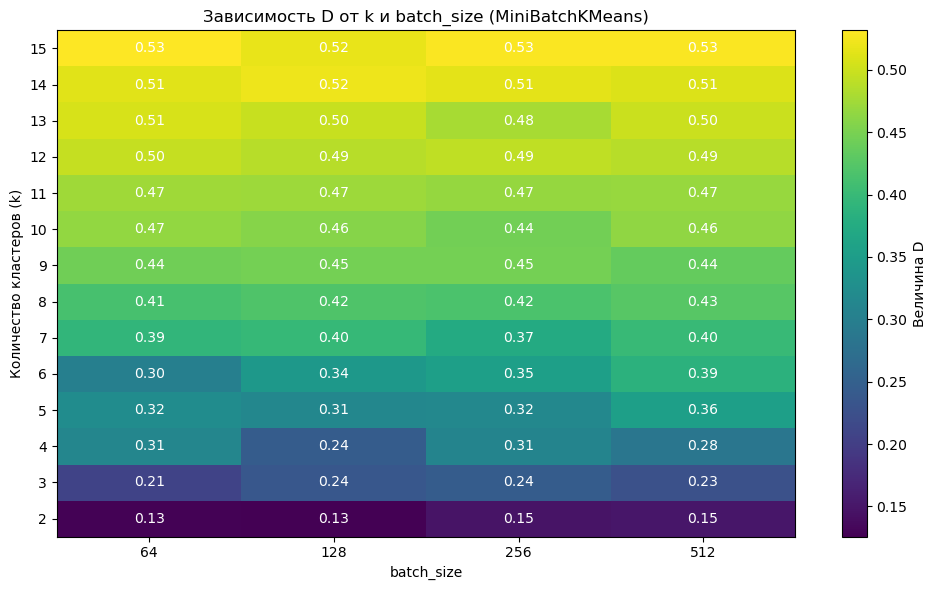

In [42]:
import matplotlib.pyplot as plt

def calculate_D_for_minibatch_kmeans(data, k_range, batch_sizes):
    results = {}

    for k in k_range:
        for batch_size in batch_sizes:
            mbk = MiniBatchKMeans(
                n_clusters=k,
                random_state=42,
                batch_size=batch_size
            )
            mbk.fit(data)

            labels = mbk.labels_
            centers = mbk.cluster_centers_

            D = calculate_D(data, labels, centers)
            results[(k, batch_size)] = D
    return results


k_range = range(2, 16)
batch_sizes = [64, 128, 256, 512]

D_results = calculate_D_for_minibatch_kmeans(data_scaled, k_range, batch_sizes)

D_matrix = np.zeros((len(k_range), len(batch_sizes)))
for i, k in enumerate(k_range):
    for j, b in enumerate(batch_sizes):
        D_matrix[i, j] = D_results[(k, b)]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(D_matrix, aspect='auto', origin='lower', cmap='viridis')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Величина D')

ax.set_xticks(range(len(batch_sizes)))
ax.set_xticklabels(batch_sizes)
ax.set_yticks(range(len(k_range)))
ax.set_yticklabels(k_range)

ax.set_xlabel('batch_size')
ax.set_ylabel('Количество кластеров (k)')
ax.set_title('Зависимость D от k и batch_size (MiniBatchKMeans)')

# аннотации в ячейках
for i in range(D_matrix.shape[0]):
    for j in range(D_matrix.shape[1]):
        value = D_matrix[i, j]
        ax.text(
            j, i, f'{value:.2f}',
            ha='center', va='center',
            color='white'
        )

fig.tight_layout()
plt.show()


In [44]:
mbk = MiniBatchKMeans(
    n_clusters=10,
    random_state=42,
    batch_size=64
)
mbk.fit(data_scaled)

labels_mbk = mbk.labels_
centers_mbk = mbk.cluster_centers_

D_mbk = calculate_D(data_scaled, labels_mbk, centers_mbk)
print(f"Величина D для MiniBatchKMeans при K = 10, batch = 64: {D_mbk}")

Величина D для MiniBatchKMeans при K = 10, batch = 64: 0.4656813018435559


In [45]:
# Принадлежность объектов к кластерам
data['Cluster_MiniBatchKMeans'] = labels_mbk
display(data.head())

# Центры в исходных значениях
centers_mbk_original = scaler.inverse_transform(centers_mbk)

print("Центры кластеров MiniBatchKMeans в исходных значениях:\n")
display(
    pd.DataFrame(
        centers_mbk_original,
        columns=data.columns[:-3]
    )
)

print("\nЦентры кластеров MiniBatchKMeans в стандартизованных значениях:\n")
display(
    pd.DataFrame(
        centers_mbk,
        columns=data.columns[:-3]
    )
)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Cluster_KMeans,Cluster_DBSCAN,Cluster_MiniBatchKMeans
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1,-1,9
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,6,0,2
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,3,-1,4
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,-1,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,6,1,1


Центры кластеров MiniBatchKMeans в исходных значениях:



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,675.029177,35.957472,3.991279,118096.832875,1.178079,9.955857e-01,0.996339,98737.104608
1,655.017896,34.882777,6.993875,15171.982728,1.857795,9.977180e-01,0.866202,61796.329470
2,654.386685,35.353224,4.018784,12529.989353,1.883191,9.998253e-01,1.000000,141361.276954
3,650.016530,58.916514,4.912172,56497.142960,1.394056,8.387043e-01,0.760227,109926.505468
4,663.753041,37.616067,7.663845,10003.364567,1.721202,9.985690e-01,0.048533,136982.215481
5,652.026634,38.607608,4.865662,90547.710814,1.090037,-2.320366e-14,0.432697,113770.400670
6,644.776386,37.485366,5.877938,125792.930521,1.157761,9.995565e-01,0.244568,156146.837338
7,662.288958,35.695241,5.202668,24513.179700,2.029047,1.343370e-14,0.564008,111334.584450
8,657.501012,39.345852,4.818665,102021.779527,1.155665,9.972180e-01,0.001770,64799.515758
9,655.440855,35.621093,2.848076,16374.554604,1.914489,9.996200e-01,0.000285,113659.655081



Центры кластеров MiniBatchKMeans в стандартизованных значениях:



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.231886,-0.244544,-0.366721,0.996836,-0.687882,0.561014,0.997148,-0.275144
1,-0.017933,-0.365743,0.703284,-0.641638,0.554397,0.565965,0.736872,-1.009659
2,-0.025813,-0.312688,-0.356919,-0.683697,0.600811,0.570857,1.004470,0.572378
3,-0.080369,2.344672,-0.038551,0.016222,-0.293154,0.196771,0.524919,-0.052658
4,0.091116,-0.057495,0.942035,-0.723918,0.304754,0.567941,-0.898483,0.485307
5,-0.055275,0.054326,-0.055126,0.558278,-0.848793,-1.750507,-0.130148,0.023772
6,-0.145787,-0.072235,0.305609,1.119352,-0.725018,0.570233,-0.506410,0.866368
7,0.072838,-0.274117,0.064970,-0.492935,0.867386,-1.750507,0.132477,-0.024660
8,0.013066,0.137582,-0.071874,0.740935,-0.728847,0.564804,-0.992009,-0.949945
9,-0.012653,-0.282479,-0.774113,-0.622495,0.658014,0.570381,-0.994980,0.021570


In [46]:
target_in_cluster(data, labels_kmeans, 'Cluster_MiniBatchKMeans')

Cluster 0: Target 0.12884691962000114
Cluster 1: Target 0.06546925344484815
Cluster 2: Target 0.06734218946960148
Cluster 3: Target 0.4347989477639985
Cluster 4: Target 0.22006047061916656
Cluster 5: Target 0.34463967405143875
Cluster 6: Target 0.31728905543351854
Cluster 7: Target 0.09540968196772677
Cluster 8: Target 0.39552029209380707
Cluster 9: Target 0.17885906040268457


Выводы

1. Алгоритмы типа Kmeans хорошо интерпритируемы, поэтому в работе я бы использовал их. Так у них схожие результаты.

2. Алгоритм DBScan имеет лучшую характеристику, но и разбил на множество категорий, которые очень трудно описать. Это хороший алгоритм для технической составляющей, но плохой для интерпритации и объяснения бизнесу.